In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import pyarrow.parquet as pq
from datetime import date
from google.colab import drive
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

drive.mount('/content/drive')
tracks=pd.read_csv('/content/drive/MyDrive/Ta047-tp_2do_cuat_2024_grupo_2/Data/EJ4/playlist_spotify.csv')
tracks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.713000,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143
1,0.192000,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582
2,0.333000,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199
3,0.601000,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798
4,0.883000,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288
...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.000175,0.374,333827,0.943,0.000156,6,0.1250,-4.108,0,0.0556,112.084,4,0.338
746,0.001970,0.487,213000,0.867,0.006020,10,0.0968,-3.293,0,0.0543,160.048,4,0.403
747,0.916000,0.605,125867,0.314,0.000000,0,0.3590,-7.631,1,0.0327,138.148,4,0.836
748,0.168000,0.700,249493,0.823,0.000028,3,0.1220,-6.892,1,0.0373,144.060,4,0.745


In [ ]:
# Análisis de datos faltantes por variable
for column in tracks.columns:
  missing_percentage = (tracks[column].isnull().sum() / len(tracks)) * 100
  print(f"Porcentaje de datos faltantes en {column}: {missing_percentage:.2f}%")


# Análisis de datos faltantes por registro
print(tracks.isnull().sum(axis=1))
print(( tracks.isnull().sum(axis=1)/ len(tracks.columns)) * 100)



Porcentaje de datos faltantes en acousticness: 0.00%
Porcentaje de datos faltantes en danceability: 0.00%
Porcentaje de datos faltantes en duration: 0.00%
Porcentaje de datos faltantes en energy: 0.00%
Porcentaje de datos faltantes en instrumentalness: 0.00%
Porcentaje de datos faltantes en key: 0.00%
Porcentaje de datos faltantes en liveness: 0.00%
Porcentaje de datos faltantes en loudness: 0.00%
Porcentaje de datos faltantes en mode: 0.00%
Porcentaje de datos faltantes en speechiness: 0.00%
Porcentaje de datos faltantes en tempo: 0.00%
Porcentaje de datos faltantes en time_signature: 0.00%
Porcentaje de datos faltantes en valence: 0.00%
0      0
1      0
2      0
3      0
4      0
      ..
745    0
746    0
747    0
748    0
749    0
Length: 750, dtype: int64
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
745    0.0
746    0.0
747    0.0
748    0.0
749    0.0
Length: 750, dtype: float64


In [ ]:
tienen_caracter_raro = tracks.astype("str").eq("-").any()
print("Columnas con caracteres raros:")
tienen_caracter_raro

Columnas con caracteres raros:


,0
acousticness,False
danceability,False
duration,False
energy,False
instrumentalness,False
key,False
liveness,False
loudness,False
mode,False
speechiness,False


In [ ]:
# Tamaño inicial
size_antes = len(tracks)

# Eliminación de duplicados
tracks_filtrado = tracks.drop_duplicates()

# Tamaño después de la eliminación de duplicados
size_despues = len(tracks_filtrado)
print(f"Se eliminaron: {size_antes - size_despues} filas duplicadas")

# Restablecimiento del índice
tracks_filtrado.reset_index(drop=True, inplace=True)

# Extracción de las columnas numéricas para normalización
cols_numeriques = tracks_filtrado.select_dtypes(include=['float64', 'int64']).columns

# Creación de una copia de las columnas no numéricas (si existen)
cols_non_numeriques = tracks_filtrado.select_dtypes(exclude=['float64', 'int64'])


Se eliminaron: 14 filas duplicadas


Porcentaje de valores atípicos en danceability: 0.14%


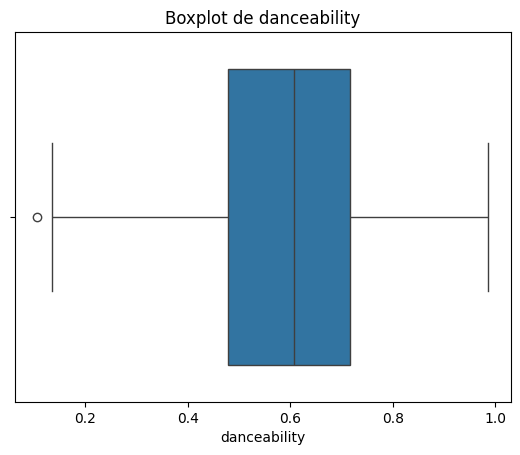

Porcentaje de valores atípicos en duration: 7.20%


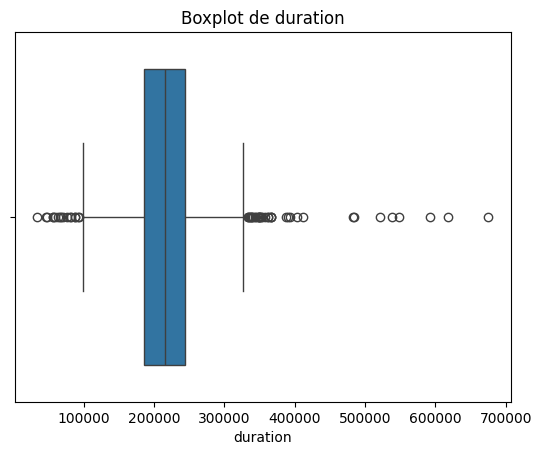

Porcentaje de valores atípicos en instrumentalness: 21.74%


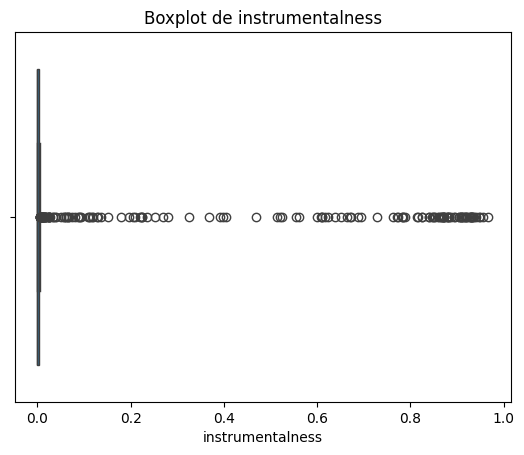

Porcentaje de valores atípicos en liveness: 6.52%


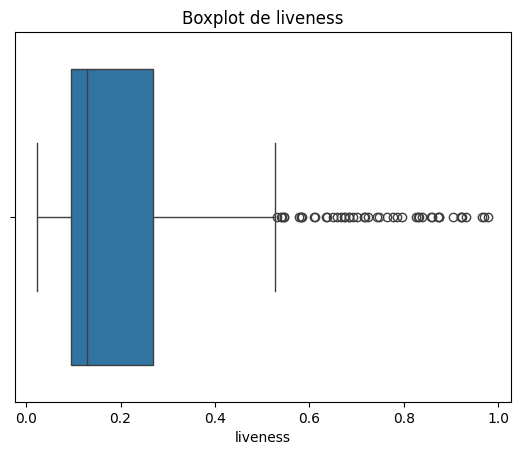

Porcentaje de valores atípicos en loudness: 6.25%


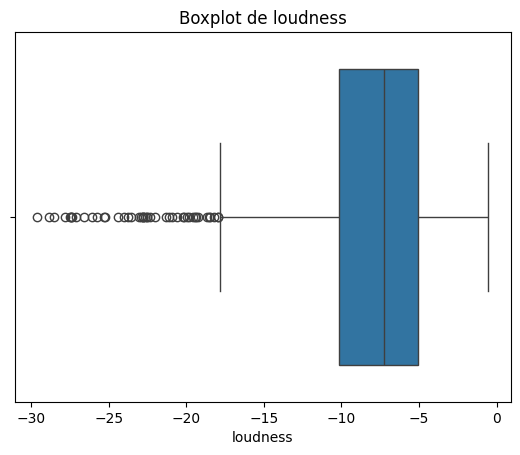

Porcentaje de valores atípicos en speechiness: 13.32%


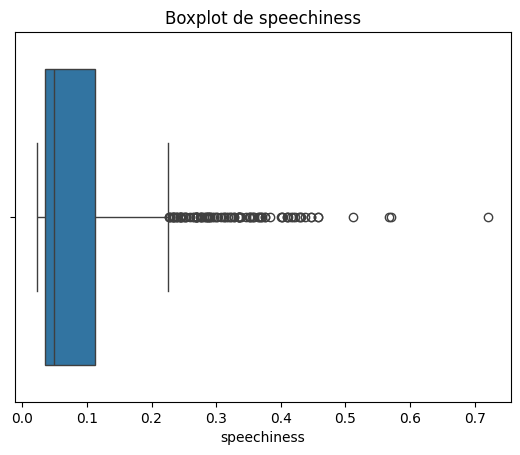

Porcentaje de valores atípicos en tempo: 0.95%


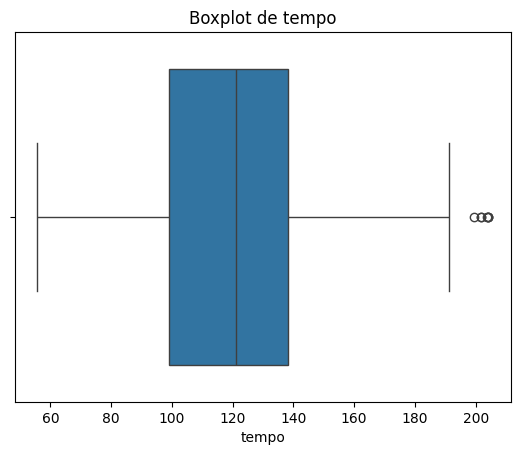

Porcentaje de valores atípicos en time_signature: 10.46%


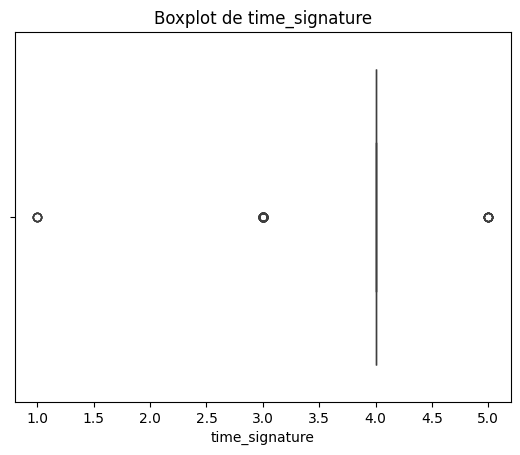

In [ ]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

for column in tracks_filtrado.select_dtypes(include=np.number):
    outliers = detect_outliers_iqr(tracks_filtrado[column])
    if not outliers.empty:
        percentage_outliers = (len(outliers) / len(tracks_filtrado[column])) * 100
        print(f"Porcentaje de valores atípicos en {column}: {percentage_outliers:.2f}%")

        # Afficher le graphique
        plt.figure()
        sns.boxplot(x=tracks_filtrado[column])
        plt.title(f"Boxplot de {column}")
        plt.show()


In [ ]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_no_outliers

tracks_sin_outliers = tracks.copy()
for column in tracks_sin_outliers.select_dtypes(include=np.number):
    tracks_sin_outliers = remove_outliers_iqr(tracks_sin_outliers, column)

print("DataFrame sin outliers:")
print(tracks_sin_outliers)


DataFrame sin outliers:
     acousticness  danceability  duration  energy  instrumentalness  key  \
1          0.1920         0.714    207019   0.614          0.000000    4   
2          0.3330         0.630    216200   0.455          0.000004    5   
4          0.8830         0.465    181440   0.459          0.000173    6   
5          0.5240         0.633    244360   0.401          0.000000    4   
6          0.5970         0.507    183573   0.795          0.000000    9   
..            ...           ...       ...     ...               ...  ...   
740        0.2020         0.755    216450   0.577          0.000000    3   
741        0.1620         0.710    309173   0.784          0.000623    0   
747        0.9160         0.605    125867   0.314          0.000000    0   
748        0.1680         0.700    249493   0.823          0.000028    3   
749        0.0155         0.477    276720   0.776          0.003140    1   

     liveness  loudness  mode  speechiness    tempo  time_signa

Comparando los resultados con y sin los outliers, no se ve mucha differencia, y tambien con el contexto de datos musicales parece bien de dejar todos los datos (incluso los mas differentes)

In [ ]:
#tracks_filtrado es el dataset original sin los datos duplicados
#tracks_sin_outliers el el dataset sin outliers filtrado

# Normalización de las columnas numéricas
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

##Dos tipos de normalisacion, el segundo es mas interesante aca
#tracks_filtrado[cols_numeriques] = scaler_minmax.fit_transform(tracks_filtrado[cols_numeriques])
tracks_filtrado[cols_numeriques] = scaler_standard.fit_transform(tracks_filtrado[cols_numeriques])


###### para comparar con el dataset sin outliers
#tracks_sin_outliers[cols_numeriques] = scaler_minmax.fit_transform(tracks_sin_outliers[cols_numeriques])
#tracks_sin_outliers[cols_numeriques] = scaler_standard.fit_transform(tracks_sin_outliers[cols_numeriques])



<ipython-input-276-a098247ec1e7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_filtrado[cols_numeriques] = scaler_standard.fit_transform(tracks_filtrado[cols_numeriques])


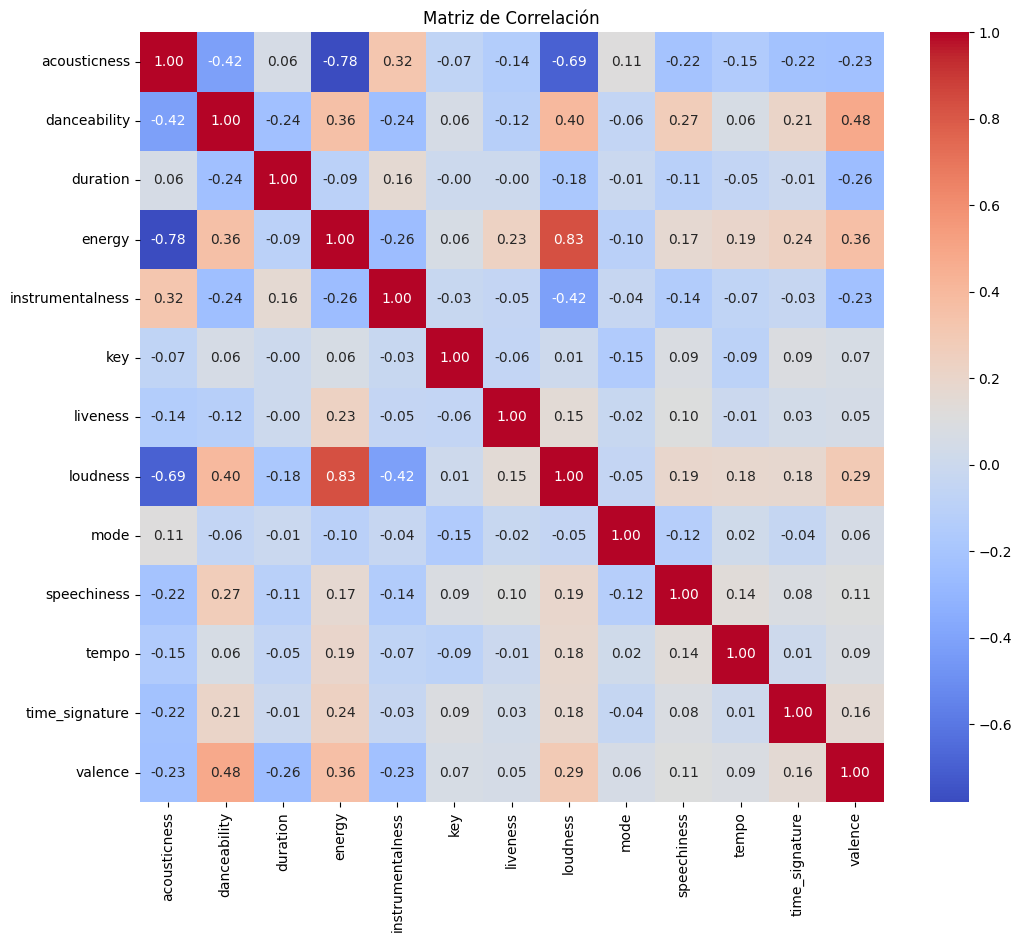

In [ ]:
correlation_matrix2 = tracks_filtrado.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


###### para comparar con el dataset sin outliers
#correlation_matrix3 = tracks_sin_outliers.corr()
#plt.figure(figsize=(12, 10))
#sns.heatmap(correlation_matrix3, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title('Matriz de Correlación')
#plt.show()

In [ ]:
##Puede ser interesante eliminar algunas variables que no son correlacionadas con las otras o que no parecen muy interesante

#tracks_filtrado = tracks_filtrado.drop(['mode', 'key', 'speechiness'], axis=1)
#tracks_sin_outliers = tracks_sin_outliers.drop(['mode', 'key', 'speechiness'], axis=1)

La correlacion parece muy cerca sin o con los outliers

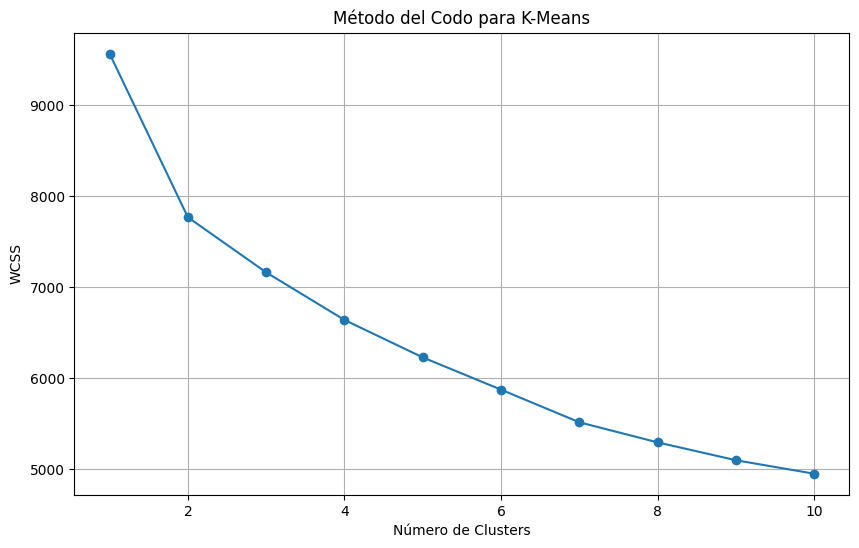

In [ ]:
k_range = range(1, 11)  # Probar de 1 a 10 clusters
wcss = []

# Calcular el WCSS para cada número de clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(tracks_filtrado)
    wcss.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.title('Método del Codo para K-Means')
plt.grid(True)
plt.show()



###### para comparar con el dataset sin outliers
#k_range = range(1, 11)  # Probar de 1 a 10 clusters
#wcss = []

# Calcular el WCSS para cada número de clusters
#for k in k_range:
#    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
#    kmeans.fit(tracks_sin_outliers)
#    wcss.append(kmeans.inertia_)

# Graficar el método del codo
#plt.figure(figsize=(10, 6))
#plt.plot(k_range, wcss, marker='o')
#plt.xlabel('Número de Clusters')
#plt.ylabel('WCSS')
#plt.title('Método del Codo para K-Means sin outliers')
#plt.grid(True)
#plt.show()

2 o 3 Grupos parecen bien

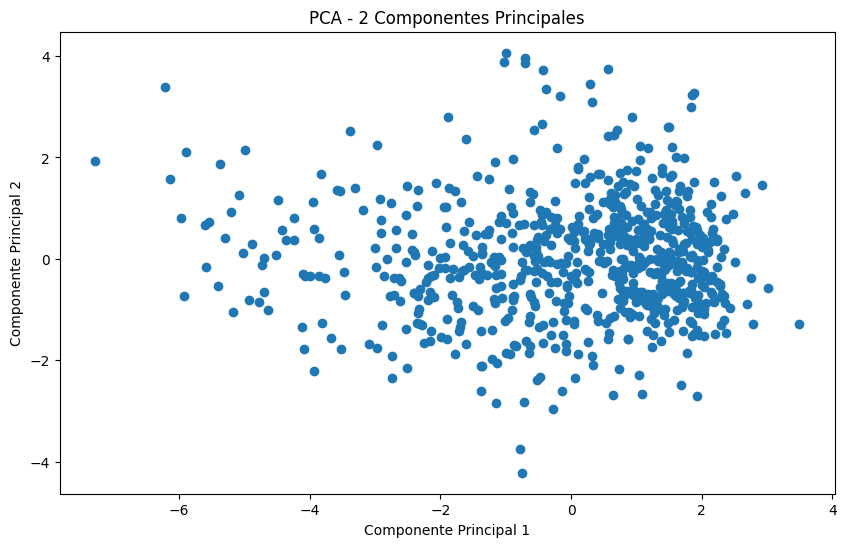

In [ ]:
# Aplicar PCA con 2 componentes principales
pca = PCA(n_components=2)
principal_components = pca.fit_transform(tracks_filtrado)

# Crear un DataFrame con las componentes principales
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Visualizar los datos en 2D
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - 2 Componentes Principales')
plt.show()


###### para comparar con el dataset sin outliers
#############################################
# Aplicar PCA con 2 componentes principales
#pca = PCA(n_components=2)
#principal_components_so = pca.fit_transform(tracks_sin_outliers)

# Crear un DataFrame con las componentes principales
#principal_df_so = pd.DataFrame(data=principal_components_so, columns=['PC1', 'PC2'])

# Visualizar los datos en 2D
#plt.figure(figsize=(10, 6))
#plt.scatter(principal_df_so['PC1'], principal_df_so['PC2'])
#plt.xlabel('Componente Principal 1')
#plt.ylabel('Componente Principal 2')
#plt.title('PCA - 2 Componentes Principales')
#plt.show()


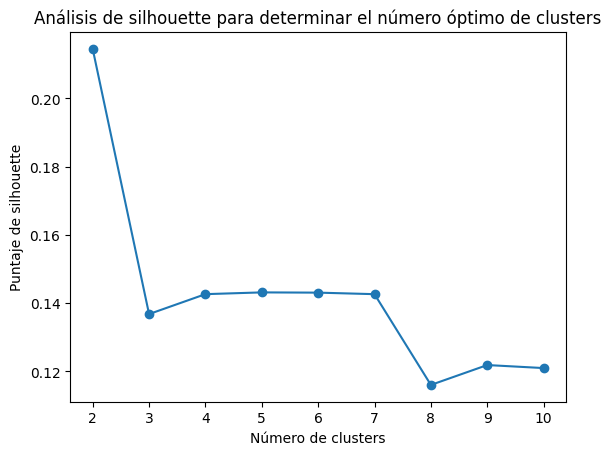

El número óptimo de clusters según el análisis de silhouette es: 2


In [ ]:
range_n_clusters = range(2, 11)  # Explora de 2 a 10 clusters
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(tracks_filtrado)
    silhouette_avg = silhouette_score(tracks_filtrado, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Trazar los puntajes de silhouette para diferentes números de clusters
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Puntaje de silhouette')
plt.title('Análisis de silhouette para determinar el número óptimo de clusters')
plt.show()

# Elegir el número de clusters que corresponde al puntaje de silhouette más alto
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"El número óptimo de clusters según el análisis de silhouette es: {optimal_n_clusters}")



###### para comparar con el dataset sin outliers
###########################################################
#range_n_clusters = range(2, 11)  # Explora de 2 a 10 clusters
#silhouette_scores = []

#for n_clusters in range_n_clusters:
#    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
#    cluster_labels = kmeans.fit_predict(tracks_sin_outliers)
#    silhouette_avg = silhouette_score(tracks_sin_outliers, cluster_labels)
#    silhouette_scores.append(silhouette_avg)

# Trazar los puntajes de silhouette para diferentes números de clusters
#plt.plot(range_n_clusters, silhouette_scores, marker='o')
#plt.xlabel('Número de clusters')
#plt.ylabel('Puntaje de silhouette')
#plt.title('Análisis de silhouette para determinar el número óptimo de clusters')
#plt.show()

# Elegir el número de clusters que corresponde al puntaje de silhouette más alto
#optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
#print(f"El número óptimo de clusters según el análisis de silhouette es: {optimal_n_clusters}")



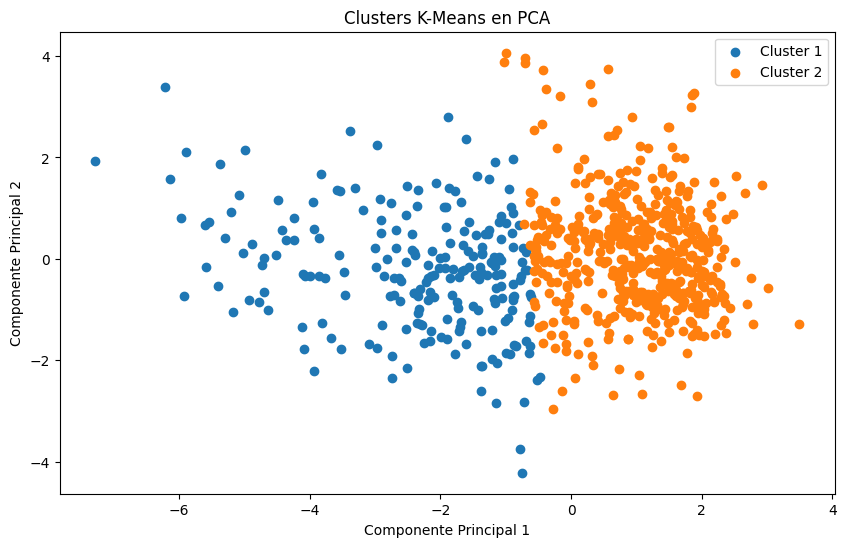

In [ ]:
# Número óptimo de clusters (según el método del codo)
n_clusters = 2  # Ajustar según el gráfico del método del codo

# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(principal_df)

# Asignar etiquetas de cluster a cada punto
labels = kmeans.labels_

# Visualizar los clusters en el gráfico de PCA
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.scatter(principal_df['PC1'][labels == i], principal_df['PC2'][labels == i], label=f'Cluster {i + 1}')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters K-Means en PCA')
plt.legend()
plt.show()



###### para comparar con el dataset sin outliers
################################################################
# Número óptimo de clusters (según el método del codo)
#n_clusters = 2  # Ajustar según el gráfico del método del codo

# Aplicar K-Means con el número óptimo de clusters
#kmeans_so = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
#kmeans_so.fit(principal_df_so)

# Asignar etiquetas de cluster a cada punto
#labels = kmeans_so.labels_

# Visualizar los clusters en el gráfico de PCA
#plt.figure(figsize=(10, 6))
#for i in range(n_clusters):
#    plt.scatter(principal_df_so['PC1'][labels == i], principal_df_so['PC2'][labels == i], label=f'Cluster {i + 1}')

#plt.xlabel('Componente Principal 1')
#plt.ylabel('Componente Principal 2')
#plt.title('Clusters K-Means en PCA')
#plt.legend()
#plt.show()


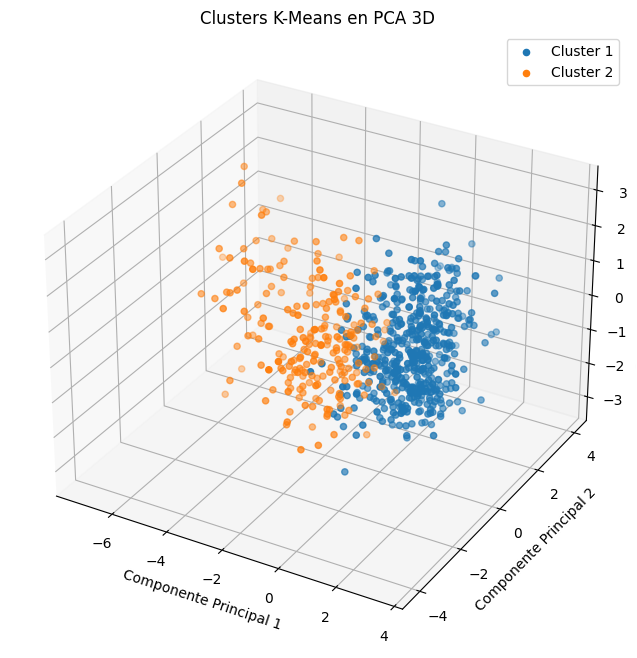

In [ ]:
# Aplicar PCA con 3 componentes principales
pca = PCA(n_components=3)
principal_components = pca.fit_transform(tracks_filtrado)

# Crear un DataFrame con las componentes principales
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Número óptimo de clusters (según el método del codo)
n_clusters = 2  # Ajustar según el gráfico del método del codo

# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(principal_df)

# Asignar etiquetas de cluster a cada punto
labels = kmeans.labels_

# Visualizar los clusters en el gráfico de PCA 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_clusters):
    ax.scatter(principal_df['PC1'][labels == i], principal_df['PC2'][labels == i], principal_df['PC3'][labels == i], label=f'Cluster {i + 1}')

ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Clusters K-Means en PCA 3D')
ax.legend()
plt.show()



###### para comparar con el dataset sin outliers
###############################################################
# Aplicar PCA con 3 componentes principales
#pca = PCA(n_components=3)
#principal_components_so = pca.fit_transform(tracks_sin_outliers)

# Crear un DataFrame con las componentes principales
#principal_df_so = pd.DataFrame(data=principal_components_so, columns=['PC1', 'PC2', 'PC3'])

# Número óptimo de clusters (según el método del codo)
#n_clusters = 2  # Ajustar según el gráfico del método del codo

# Aplicar K-Means con el número óptimo de clusters
#kmeans_so = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
#kmeans_so.fit(principal_df_so)

# Asignar etiquetas de cluster a cada punto
#labels = kmeans_so.labels_

# Visualizar los clusters en el gráfico de PCA 3D
#fig = plt.figure(figsize=(10, 8))
#ax = fig.add_subplot(111, projection='3d')

#for i in range(n_clusters):
#    ax.scatter(principal_df_so['PC1'][labels == i], principal_df_so['PC2'][labels == i], principal_df_so['PC3'][labels == i], label=f'Cluster {i + 1}')

#ax.set_xlabel('Componente Principal 1')
#ax.set_ylabel('Componente Principal 2')
#ax.set_zlabel('Componente Principal 3')
#ax.set_title('Clusters K-Means en PCA 3D')
#ax.legend()
#plt.show()


In [ ]:
cluster_labels = kmeans.fit_predict(tracks_filtrado)
silhouette_avg = silhouette_score(tracks_filtrado, cluster_labels)
print(f"Silhouette Score para tracks_filtrado con 2 clusters: {silhouette_avg}")

cluster_labels = kmeans.fit_predict(principal_df)
silhouette_avg = silhouette_score(principal_df, cluster_labels)
print(f"Silhouette Score para tracks_filtrado con 2 clusters en el epacio reducto por la PCA: {silhouette_avg}")


###### para comparar con el dataset sin outliers
#cluster_labels_so = kmeans_so.fit_predict(tracks_sin_outliers)
#silhouette_avg_so = silhouette_score(tracks_sin_outliers, cluster_labels_so)
#print(f"Silhouette Score para tracks_sin_outliers con 2 clusters: {silhouette_avg_so}")

Silhouette Score para tracks_filtrado con 2 clusters: 0.2144925961821456
Silhouette Score para tracks_filtrado con 2 clusters en el epacio reducto por la PCA: 0.38927335661180523


<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


<Figure size 1500x1000 with 0 Axes>

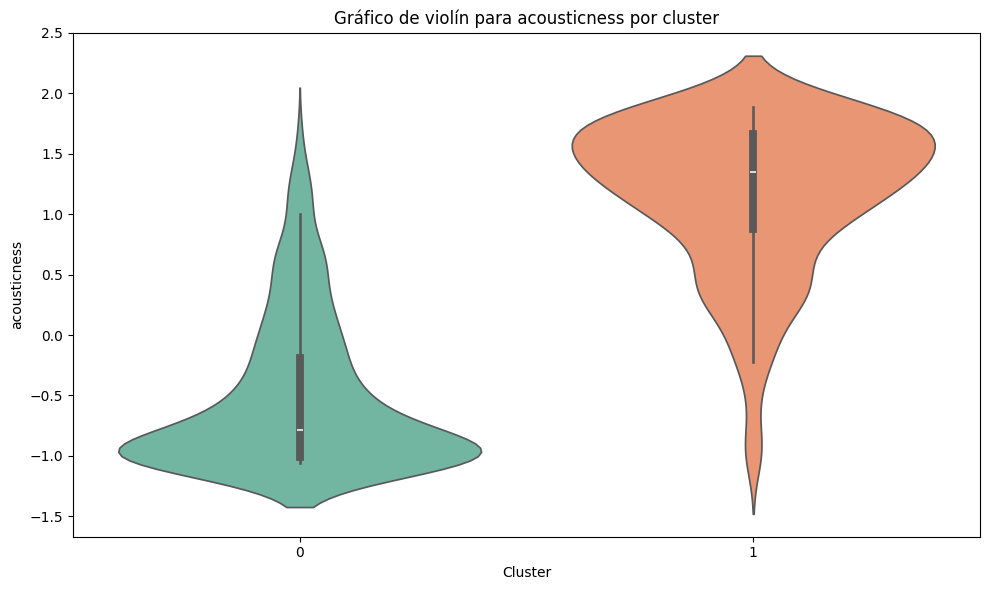

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


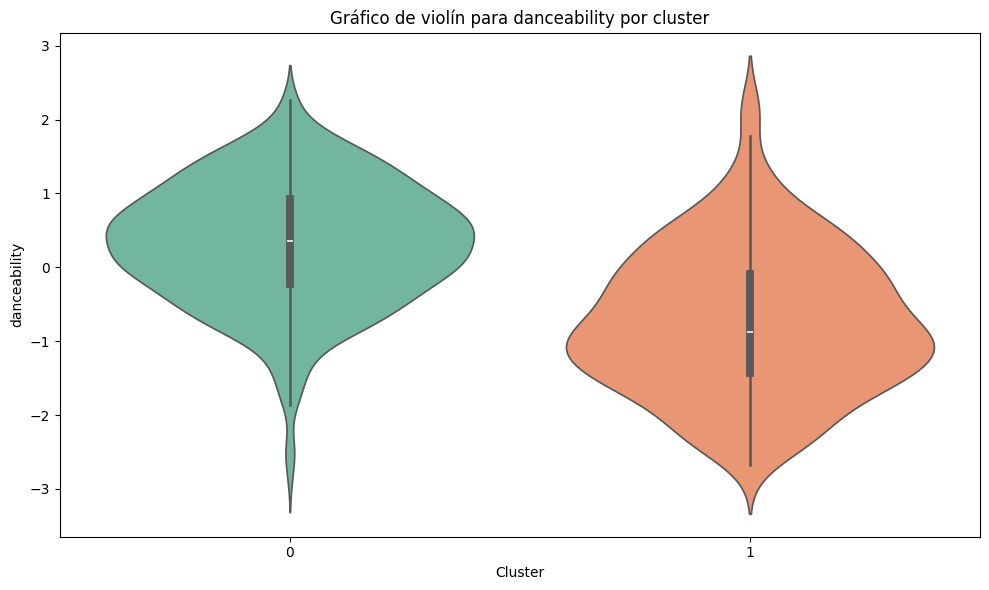

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


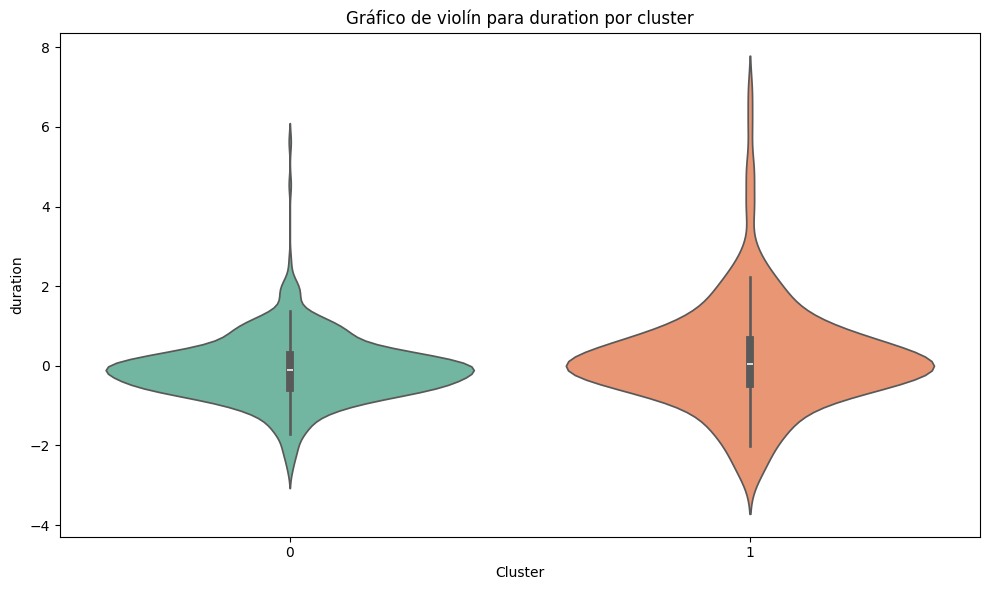

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


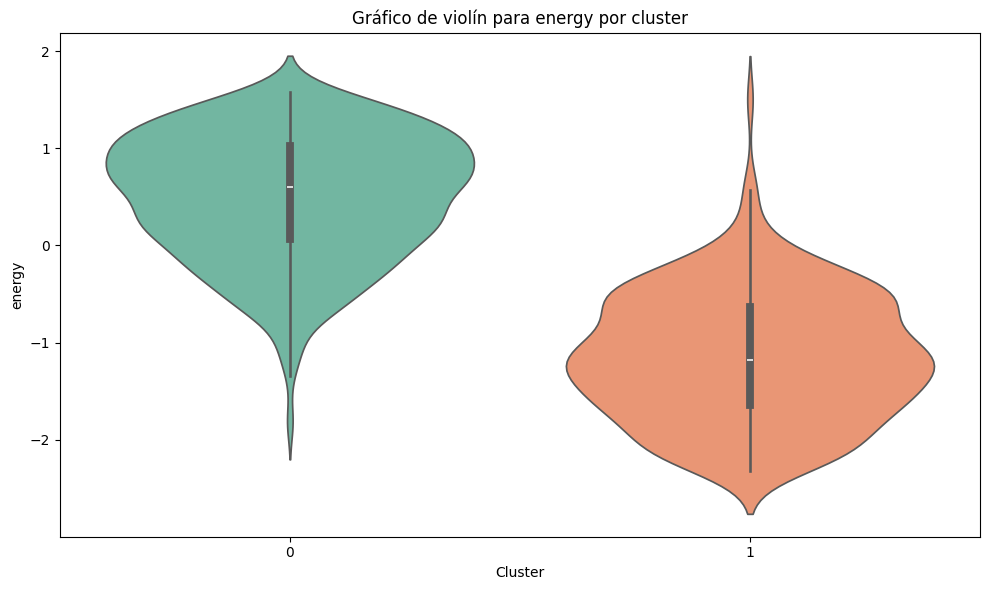

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


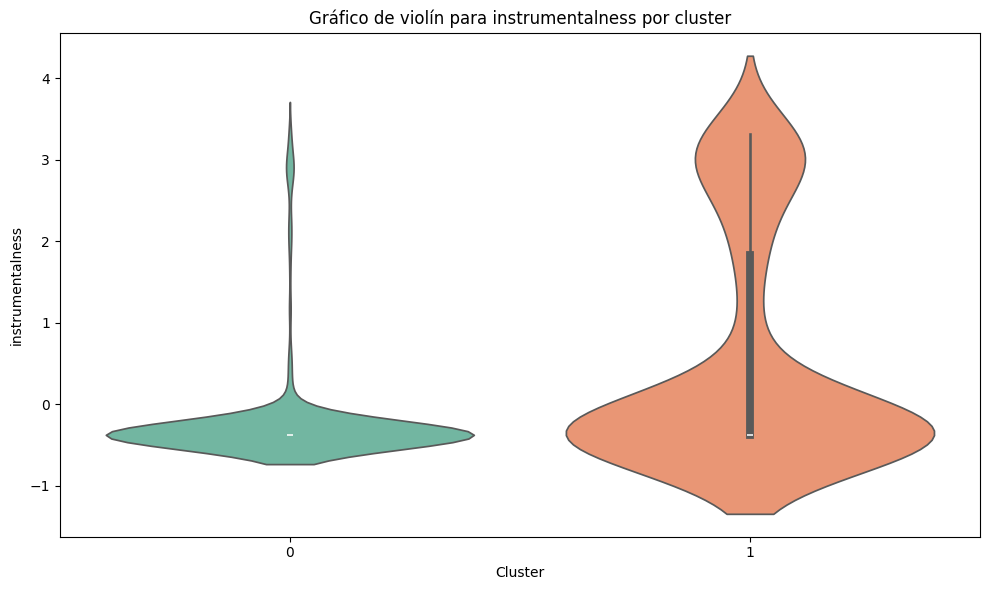

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


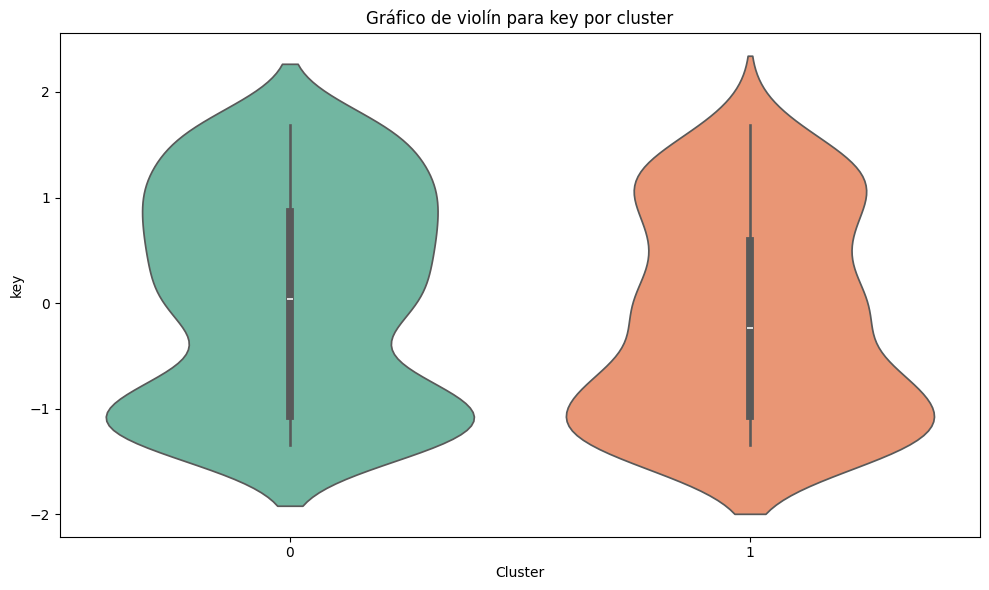

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


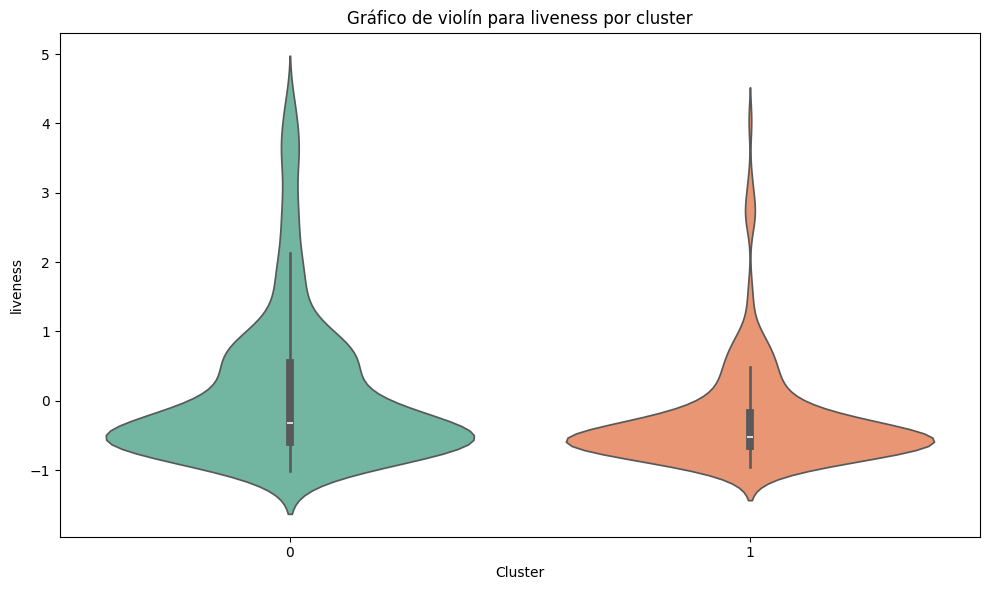

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


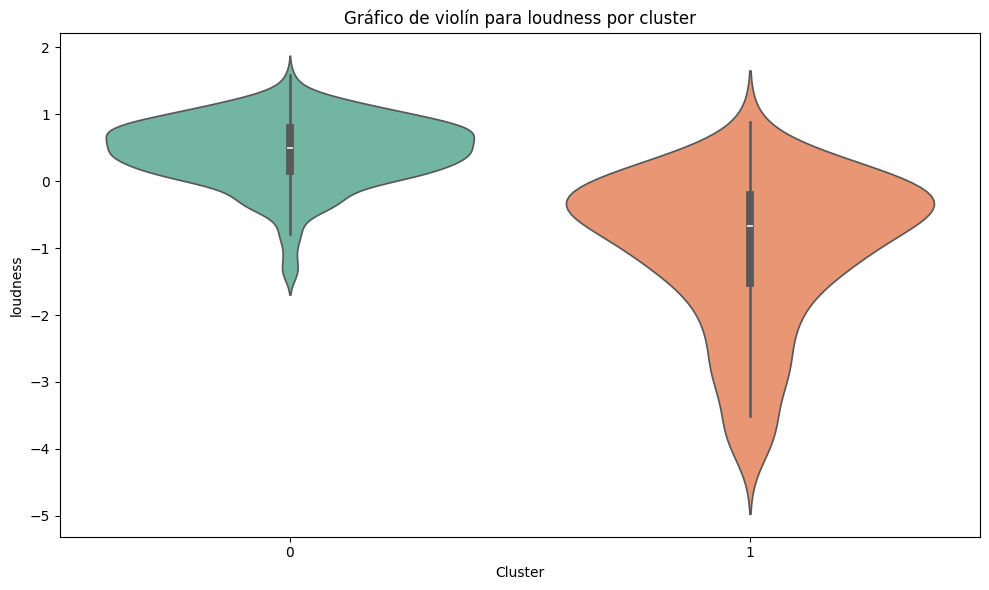

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


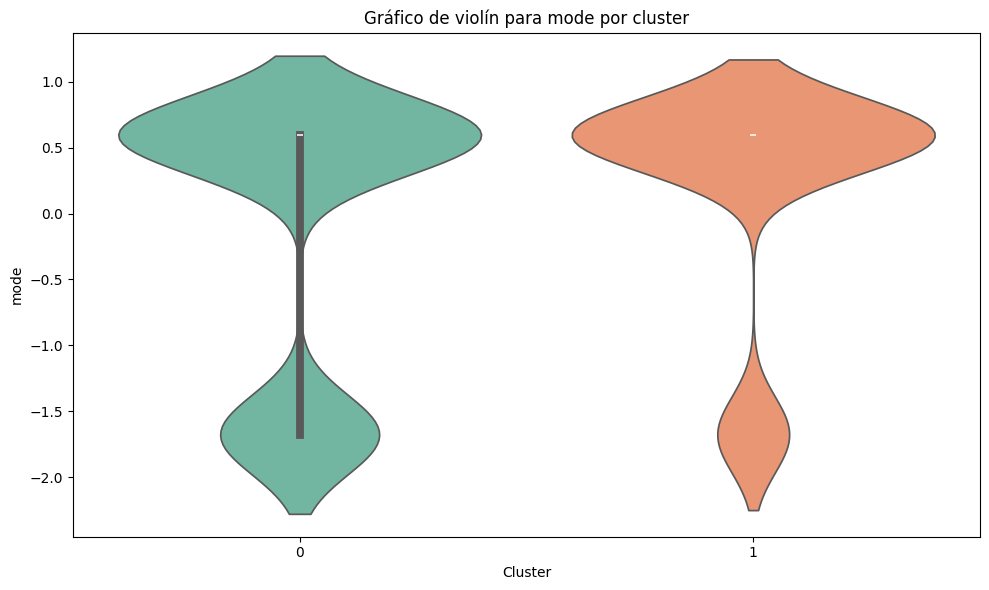

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


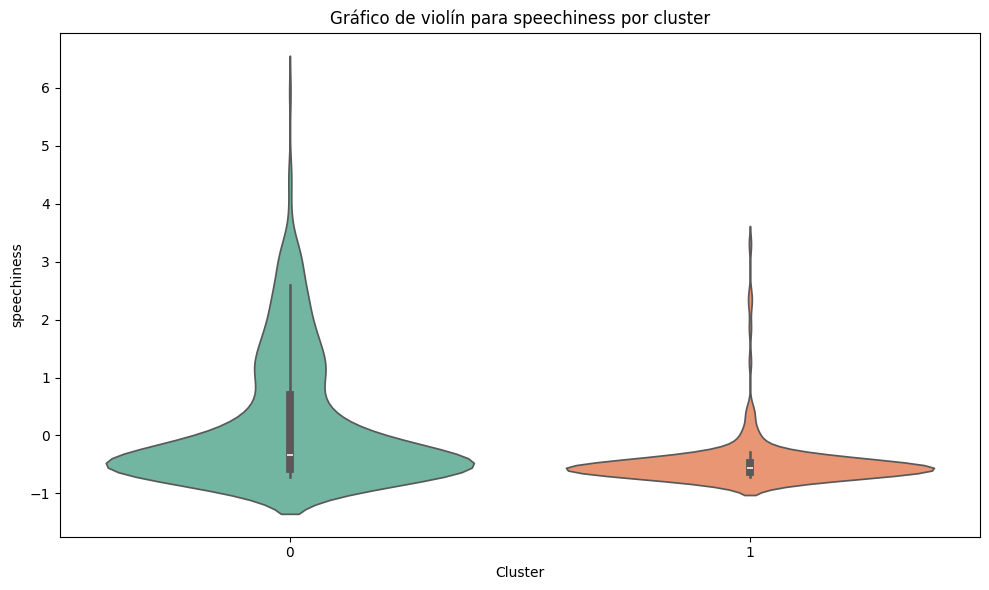

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


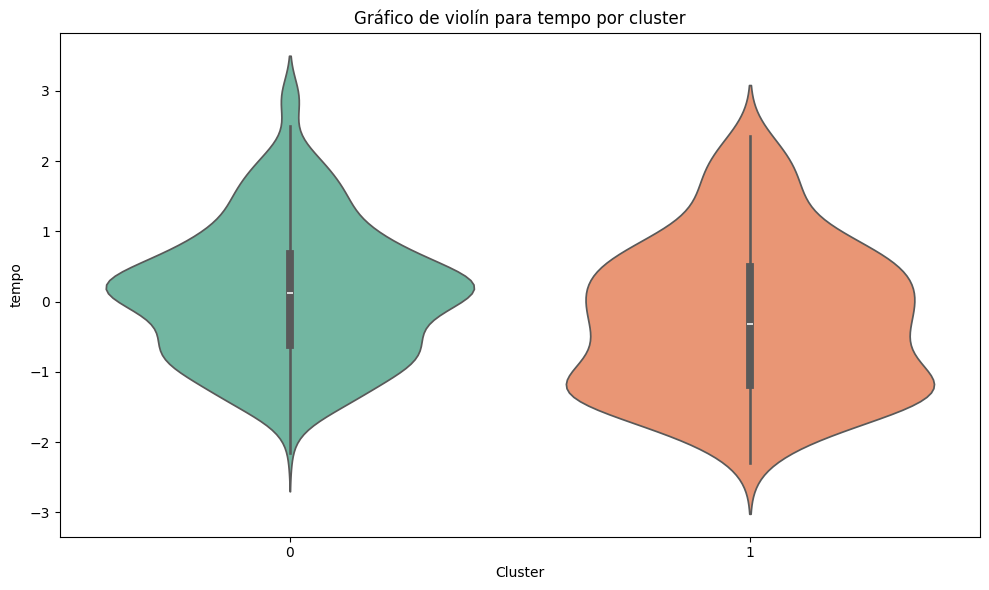

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


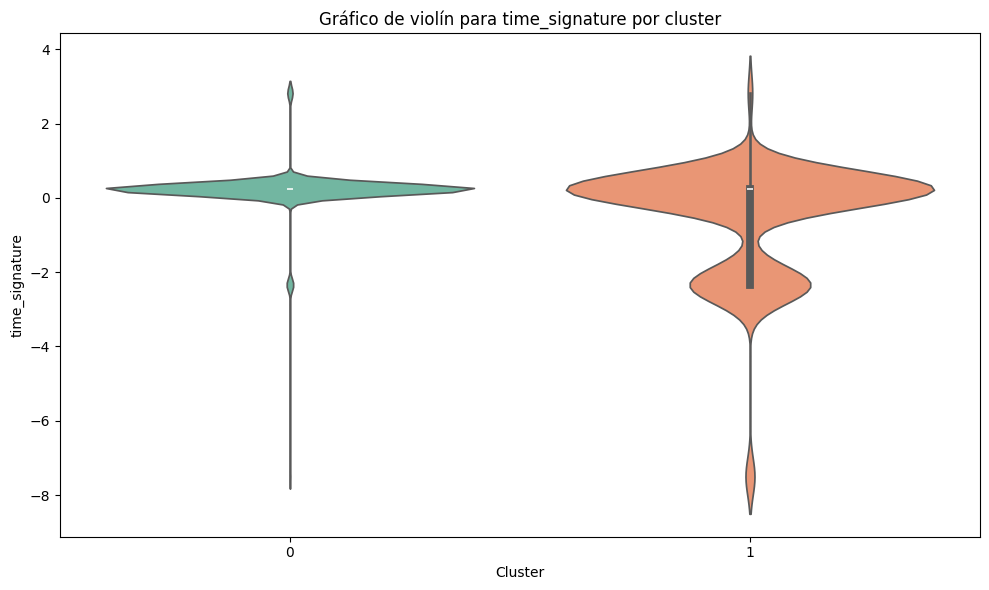

<ipython-input-285-67545f317876>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


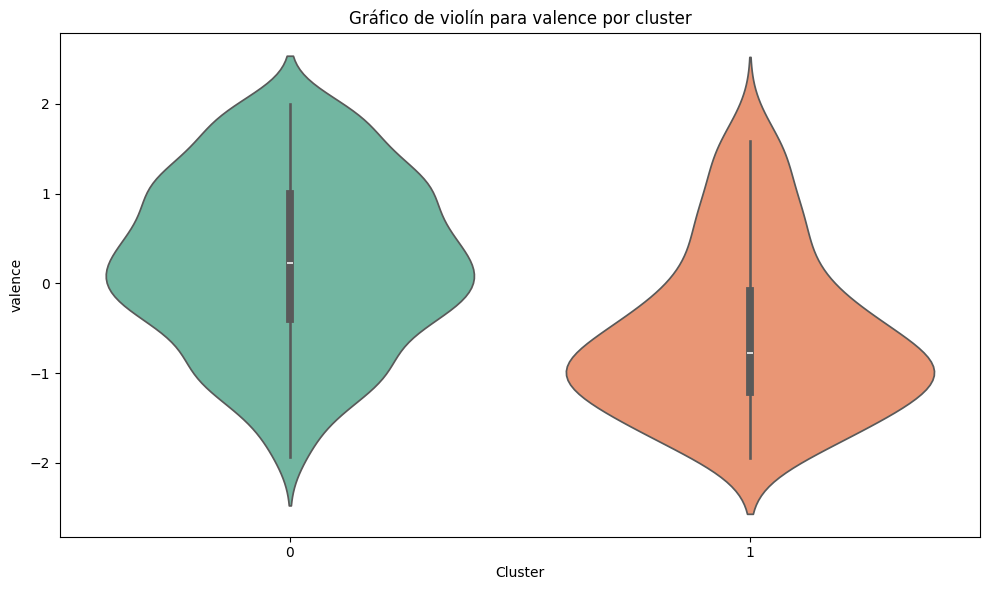

In [ ]:
clustered_data = pd.concat([tracks_filtrado, pd.DataFrame({'cluster': labels})], axis=1)

# Creación de gráficos de violín para comparar variables en cada cluster
plt.figure(figsize=(15, 10))

# Para cada variable, crea un gráfico de violín comparando ambos clusters
for col in tracks_filtrado.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")
    plt.title(f'Gráfico de violín para {col} por cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Con los dos tipos de normalisacion :

- MinMax Scaler : dos grupos muy distinctos Mode=1 y Mode=0
-Standard Scaler : dos gruppos mas interesantes 1(with energy, dansability, loudness positiveness)  2(quiet, acoustic, more negatives...)

In [ ]:
###### para comparar con el dataset sin outliers
#clustered_data_so = pd.concat([first_13_variables_so, pd.DataFrame({'cluster': labels})], axis=1)

# Creación de gráficos de violín para comparar variables en cada cluster (sin outliers)
#plt.figure(figsize=(15, 10))

# Para cada variable, crea un gráfico de violín comparando ambos clusters
#for col in first_13_variables_so.columns:
#    plt.figure(figsize=(10, 6))
#    sns.violinplot(x='cluster', y=col, data=clustered_data_so, palette="Set2")
#    plt.title(f'Gráfico de violín para {col} por cluster (sin outliers)')
#    plt.xlabel('Cluster')
#    plt.ylabel(col)
#    plt.tight_layout()
#    plt.show()



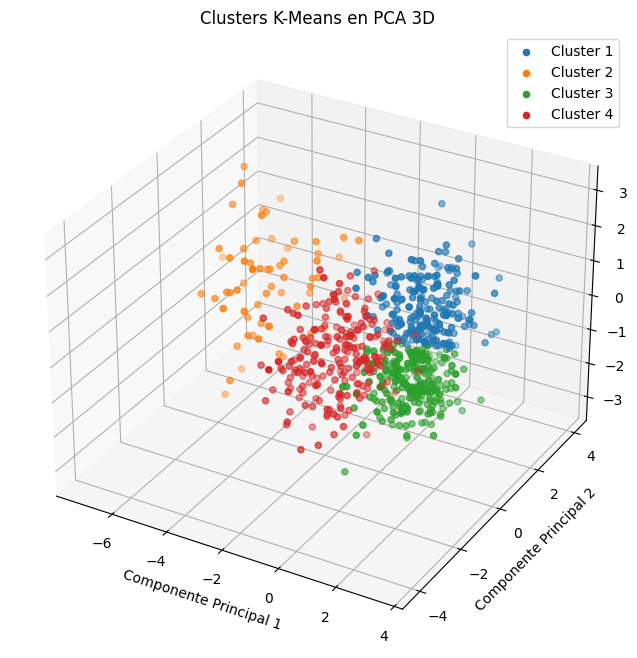

Silhouette Score para tracks_filtrado con 4 clusters: 0.14264427632422508
Silhouette Score para tracks_filtrado con 4 clusters en el epacio reducto por la PCA: 0.2670500972661875


<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


<Figure size 1500x1000 with 0 Axes>

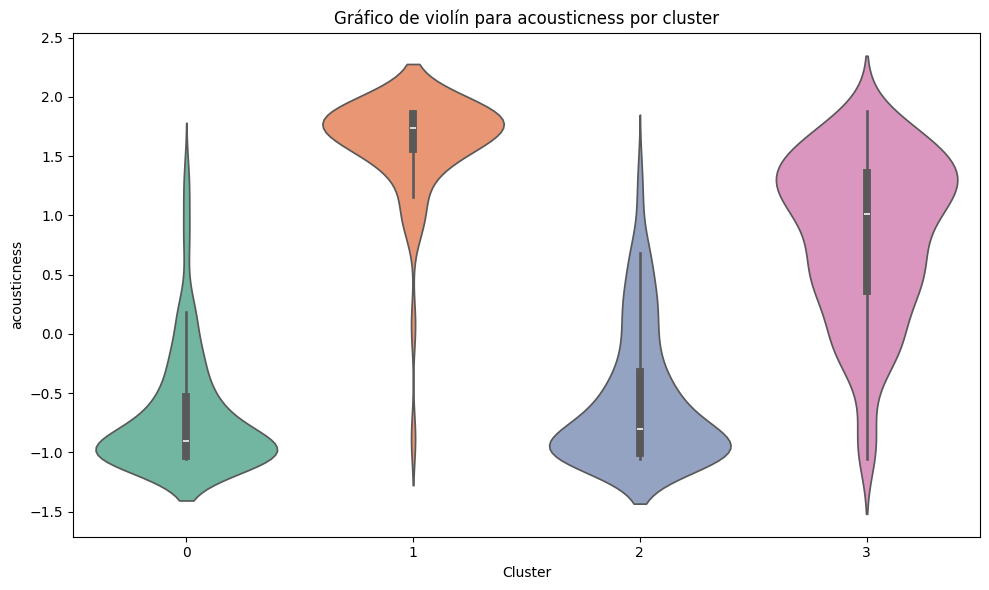

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


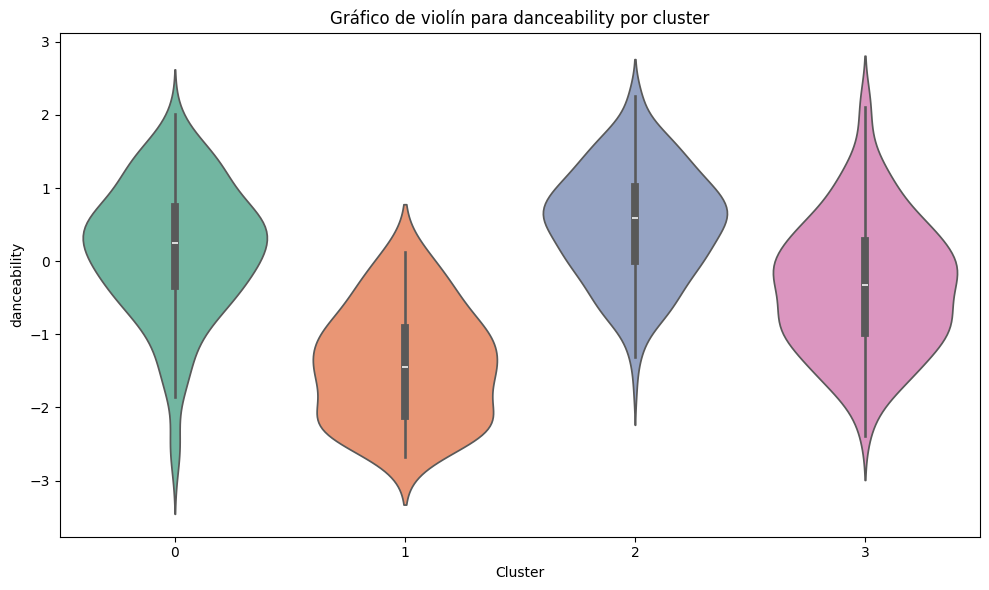

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


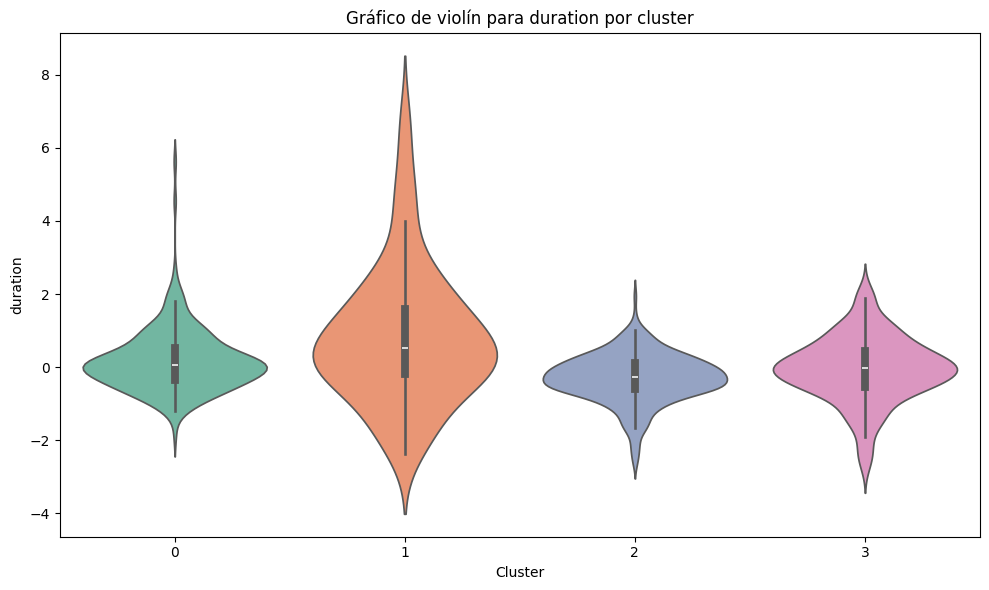

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


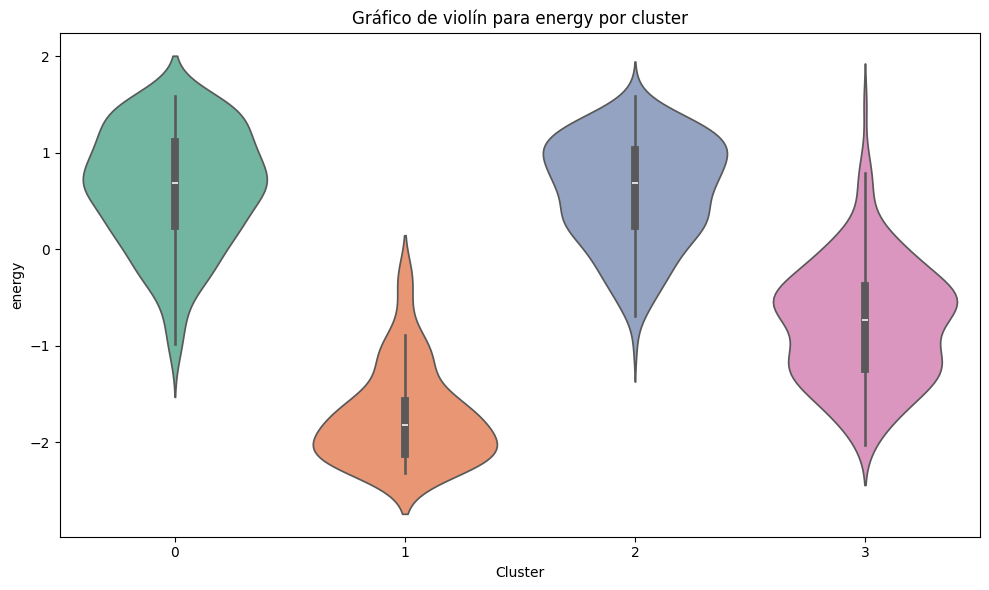

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


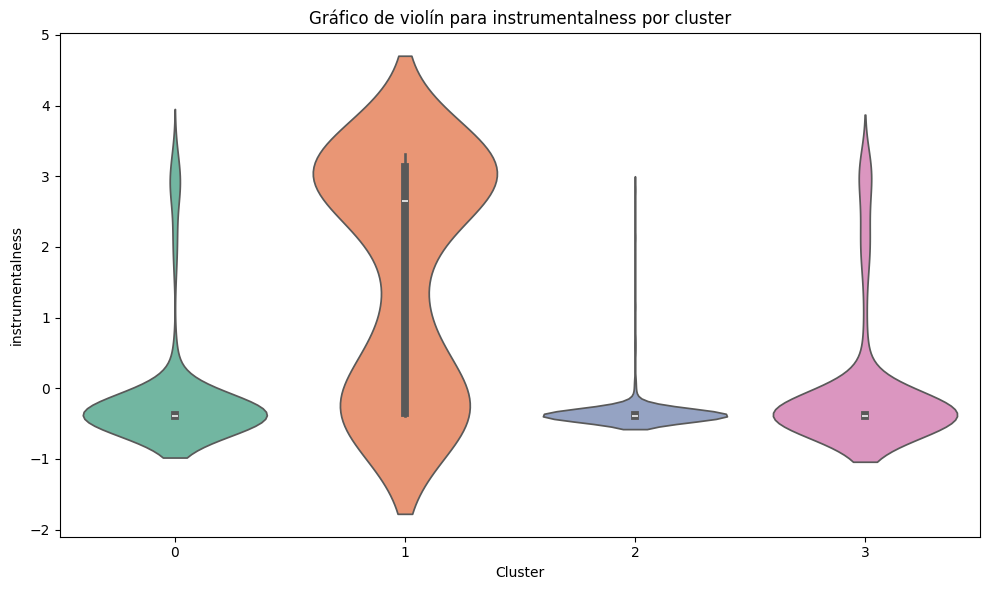

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


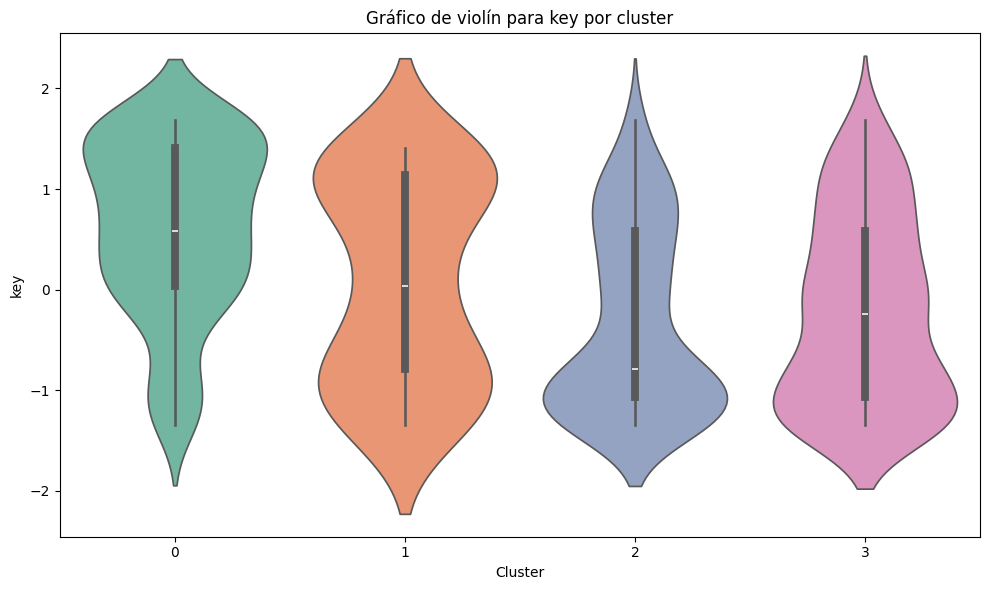

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


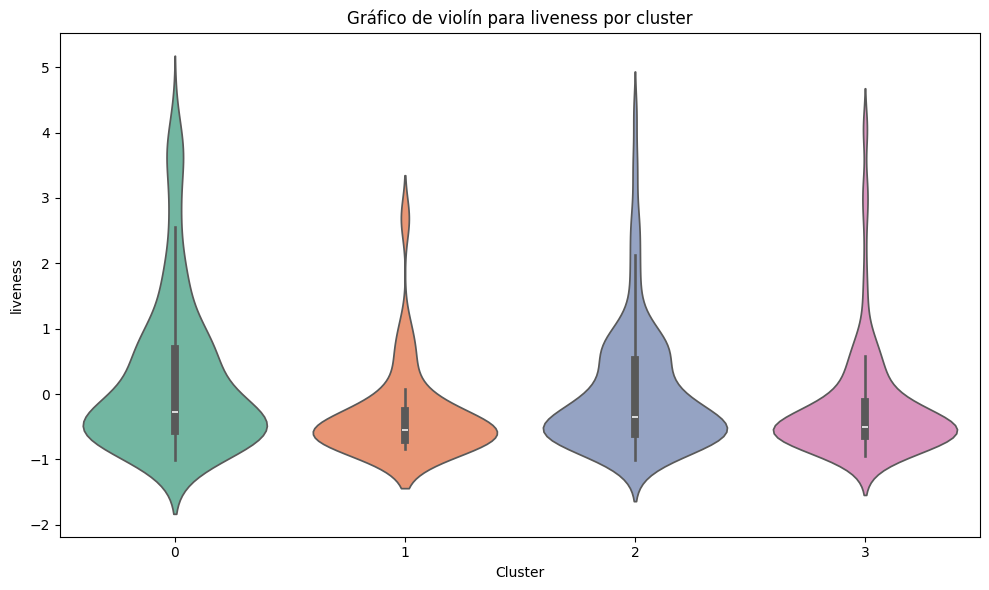

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


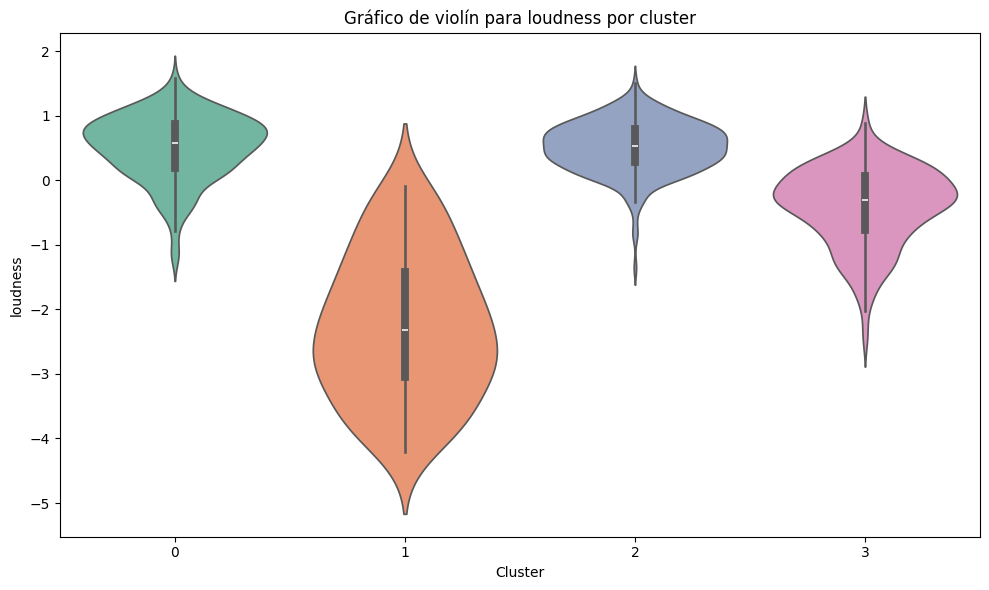

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


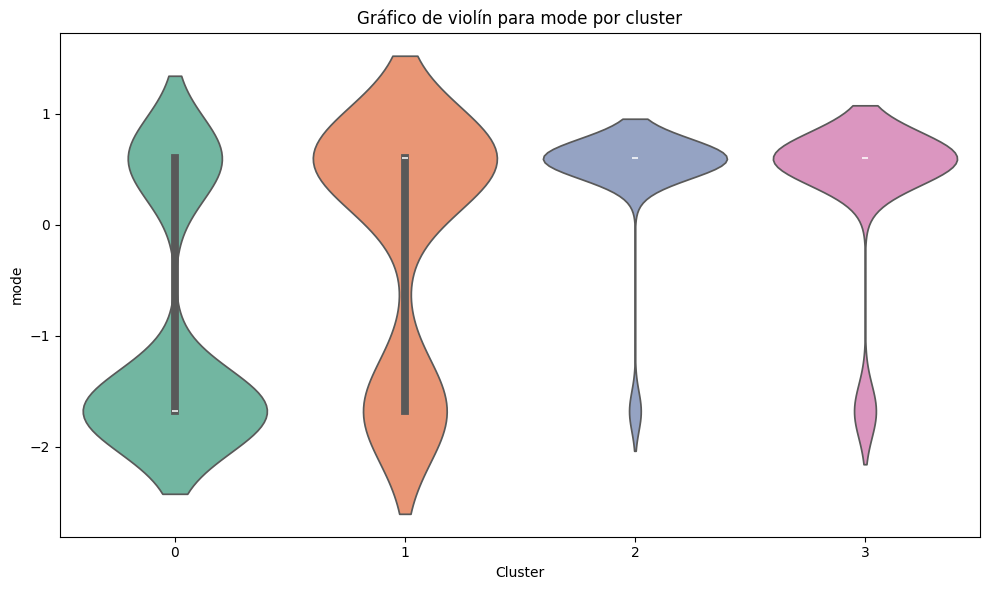

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


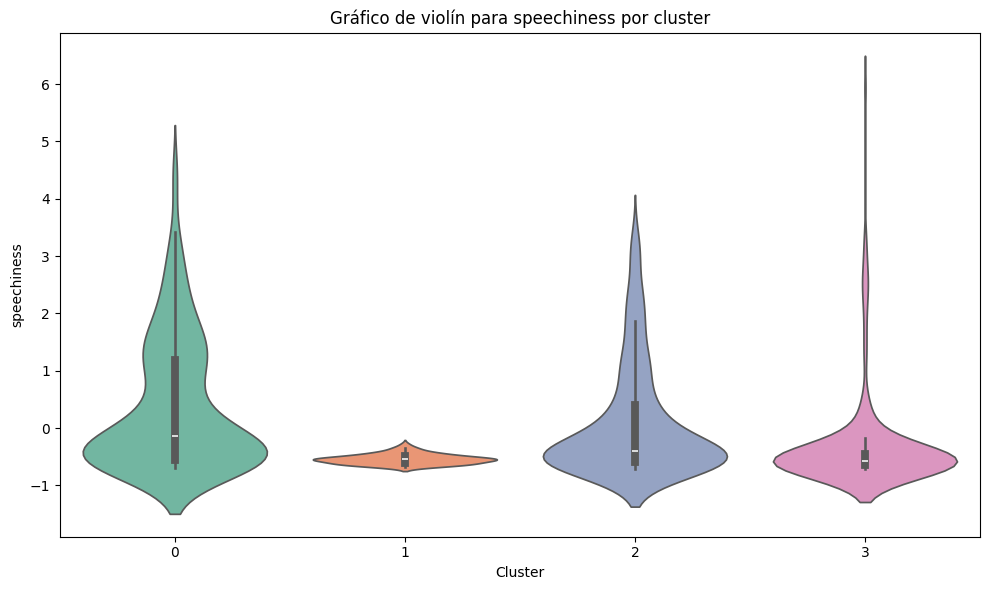

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


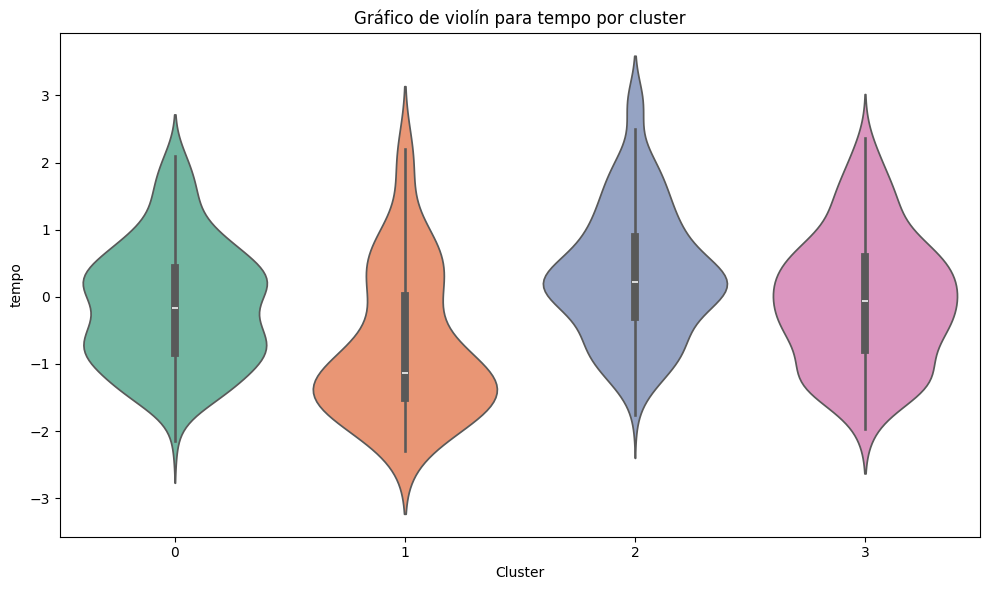

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


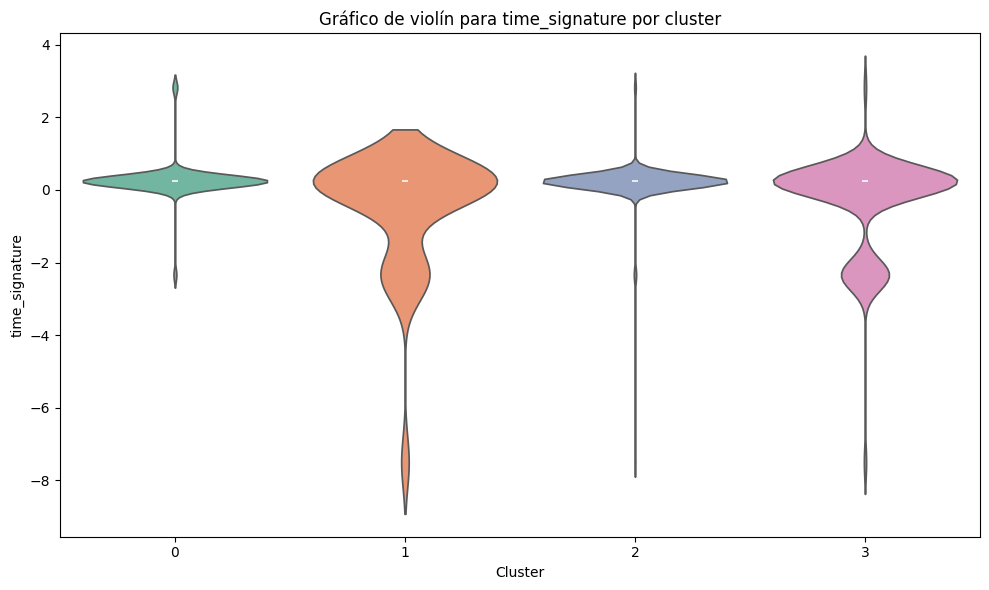

<ipython-input-287-8b781a1690ac>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")


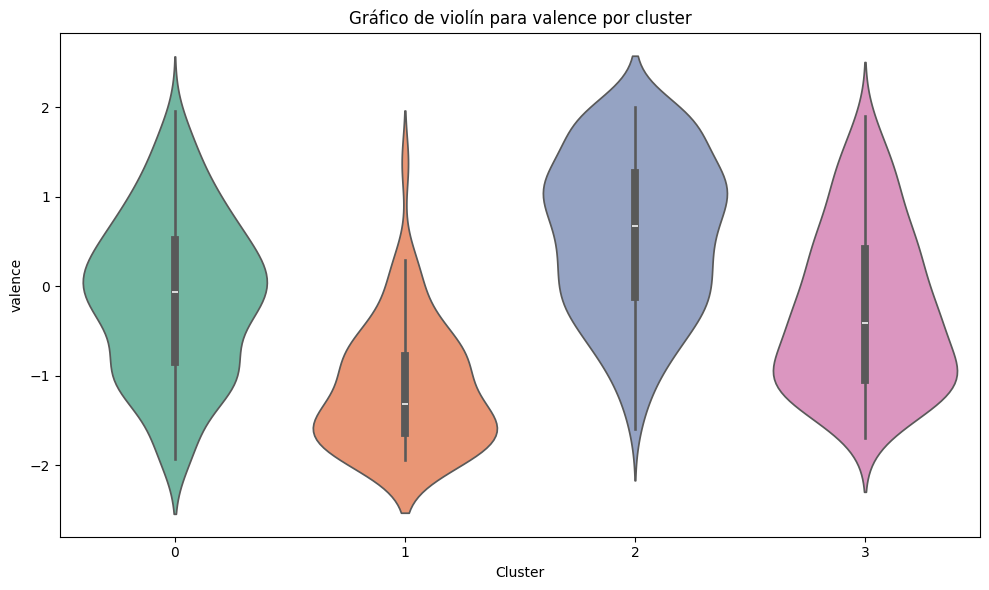

In [ ]:
#### Lo mismo con mas clusters (menos optimal pero puede ser mas interesante)
# Número óptimo de clusters (según el método del codo)
n_clusters = 4  # Ajustar según el gráfico del método del codo

# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(principal_df)

# Asignar etiquetas de cluster a cada punto
labels = kmeans.labels_

# Visualizar los clusters en el gráfico de PCA 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(n_clusters):
    ax.scatter(principal_df['PC1'][labels == i], principal_df['PC2'][labels == i], principal_df['PC3'][labels == i], label=f'Cluster {i + 1}')

ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Clusters K-Means en PCA 3D')
ax.legend()
plt.show()

cluster_labels = kmeans.fit_predict(tracks_filtrado)
silhouette_avg = silhouette_score(tracks_filtrado, cluster_labels)
print(f"Silhouette Score para tracks_filtrado con 4 clusters: {silhouette_avg}")

cluster_labels = kmeans.fit_predict(principal_df)
silhouette_avg = silhouette_score(principal_df, cluster_labels)
print(f"Silhouette Score para tracks_filtrado con 4 clusters en el epacio reducto por la PCA: {silhouette_avg}")

clustered_data = pd.concat([tracks_filtrado, pd.DataFrame({'cluster': labels})], axis=1)

# Creación de gráficos de violín para comparar variables en cada cluster
plt.figure(figsize=(15, 10))

# Para cada variable, crea un gráfico de violín comparando ambos clusters
for col in tracks_filtrado.columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='cluster', y=col, data=clustered_data, palette="Set2")
    plt.title(f'Gráfico de violín para {col} por cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


4 grupos :

0 y 2 son menos acousticos, con mas loudness, energy, danceability. La diferencia entre los dos es la key y el mode lo que resulta en 2 tiene musicas mas positivas (mejor valence) que 0

1 y 3 son musicas mas calmas, acousticas, mas tristes pero 3 es un poco menos acoustic y tiene mas energia, loudness, danceability

Pdemos hacer una scale desde musicas tranquilas y negativas hasta musicas energiticas y positivas : 1 < 3 < 0 < 2

Importancia de las características:
              Feature  Importance
11           valence    0.229071
0       acousticness    0.228561
8        speechiness    0.120018
9              tempo    0.106978
5           liveness    0.075363
2             energy    0.058064
3   instrumentalness    0.049808
1           duration    0.048392
6           loudness    0.039554
4                key    0.026223
10    time_signature    0.013891
7               mode    0.004078
Características seleccionadas: ['valence', 'acousticness', 'speechiness', 'tempo', 'liveness', 'energy', 'instrumentalness', 'duration']
Varianza explicada por cada componente: [0.4454456  0.15282924 0.12833365]


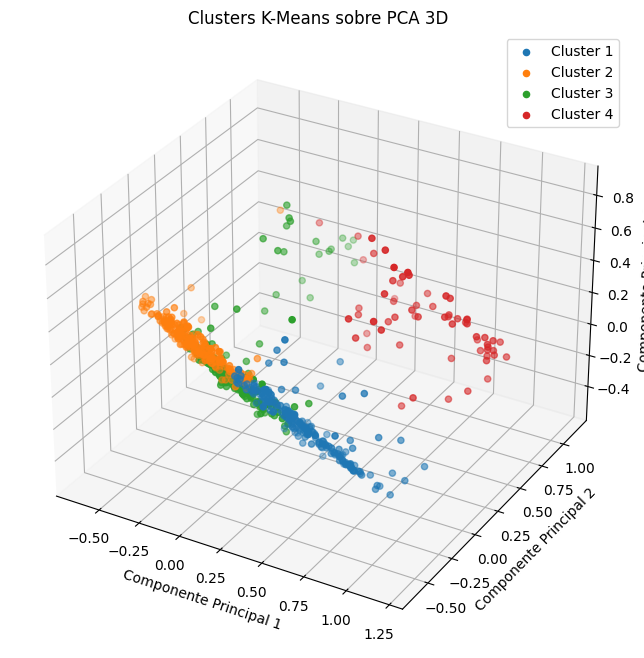

El score silhouette promedio es: 0.37439382310838315


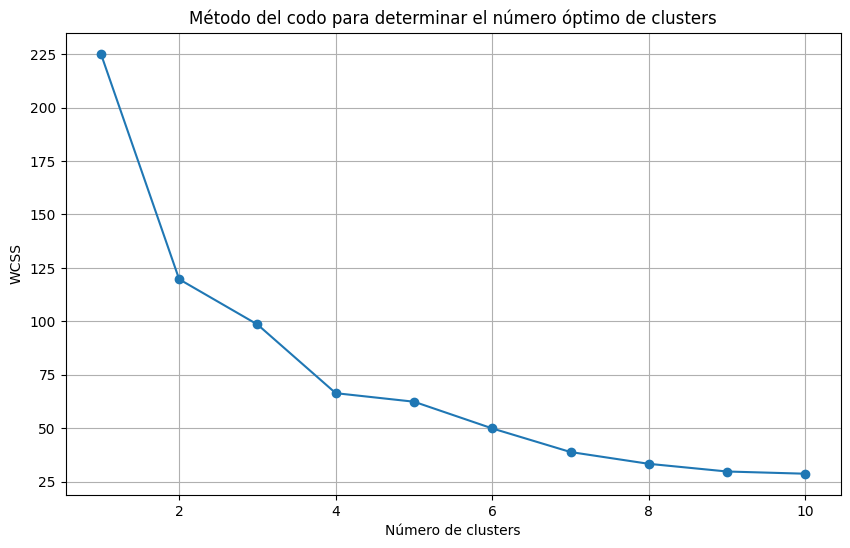

<Figure size 1500x1000 with 0 Axes>

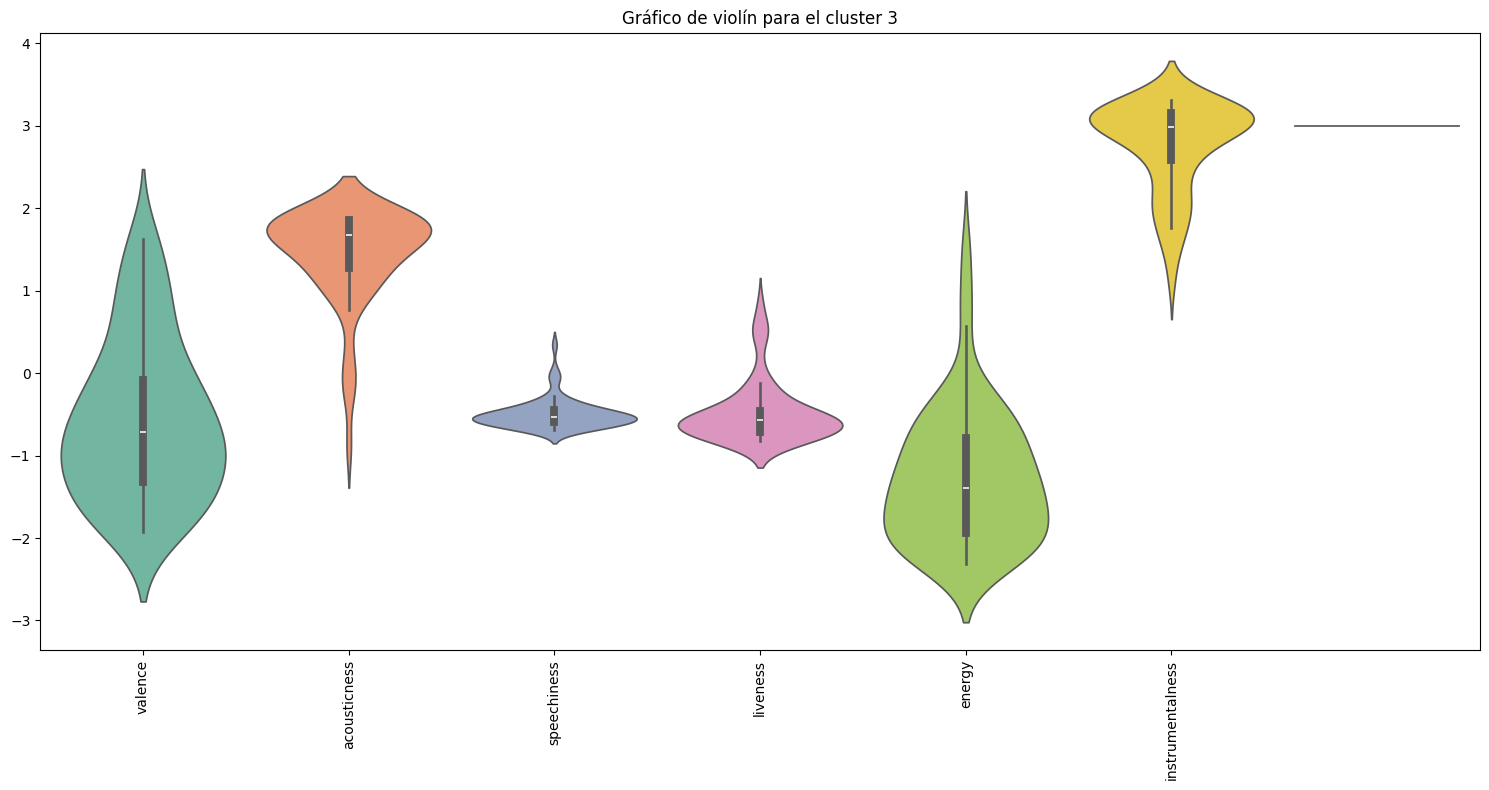

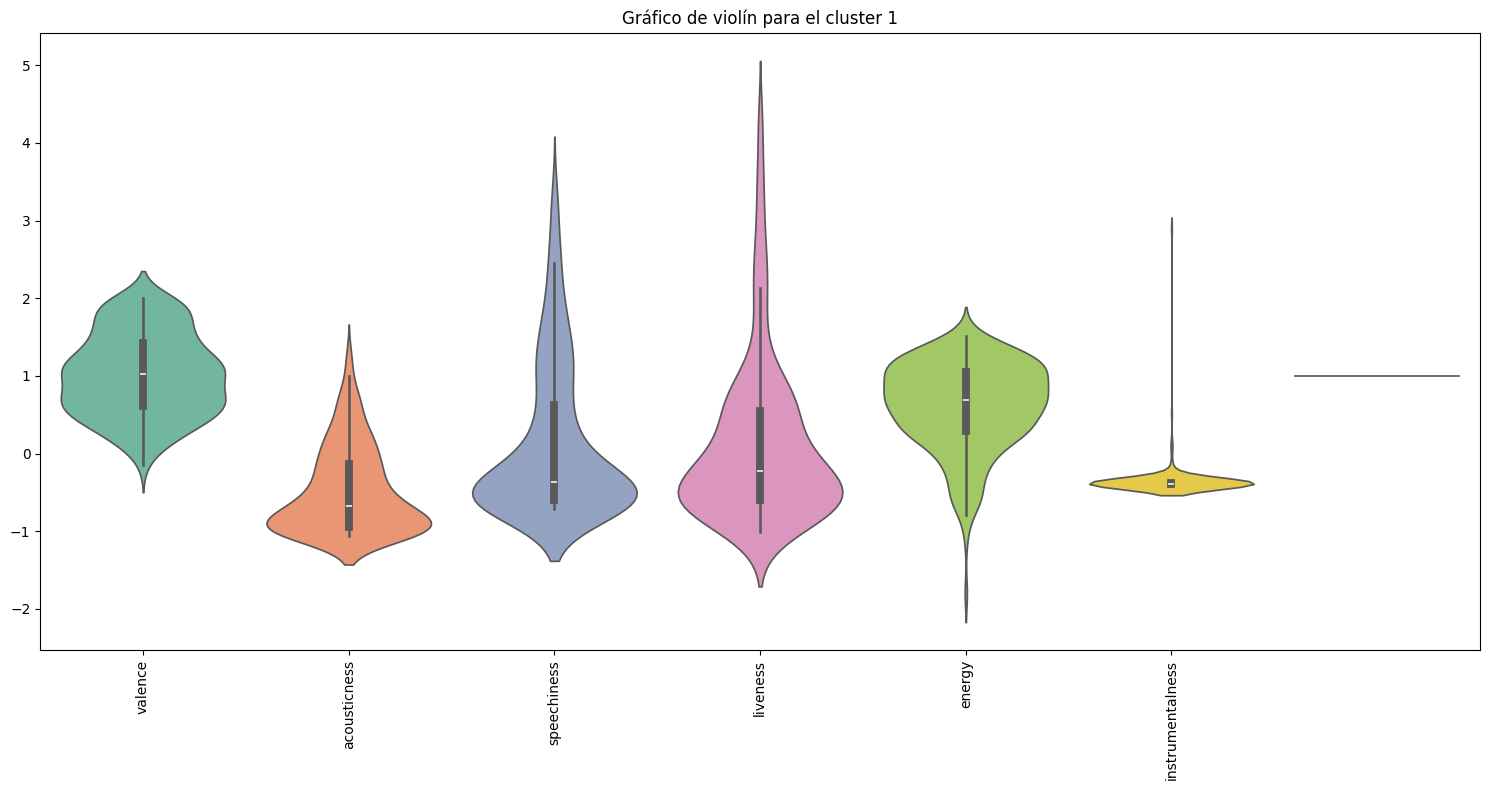

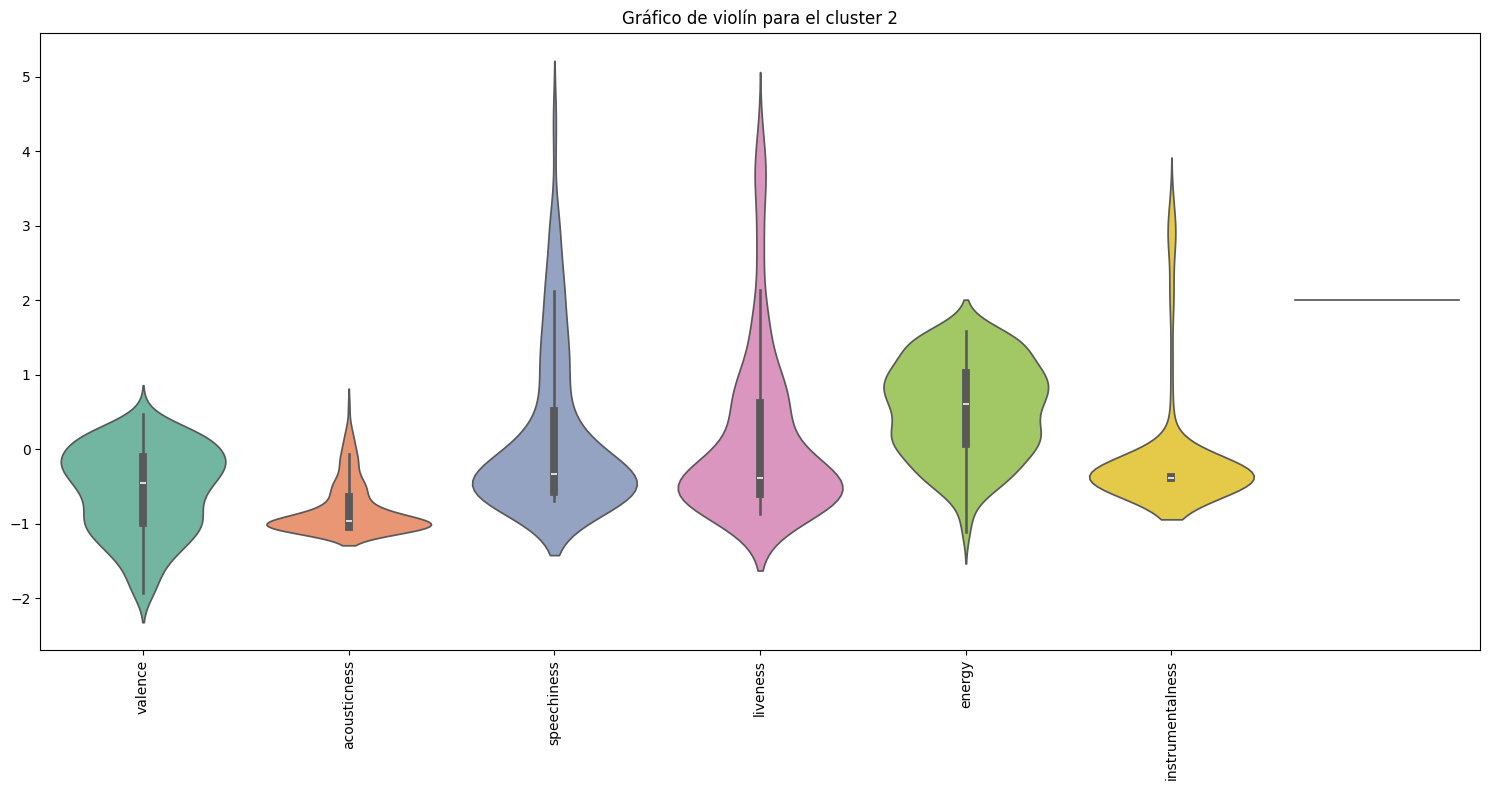

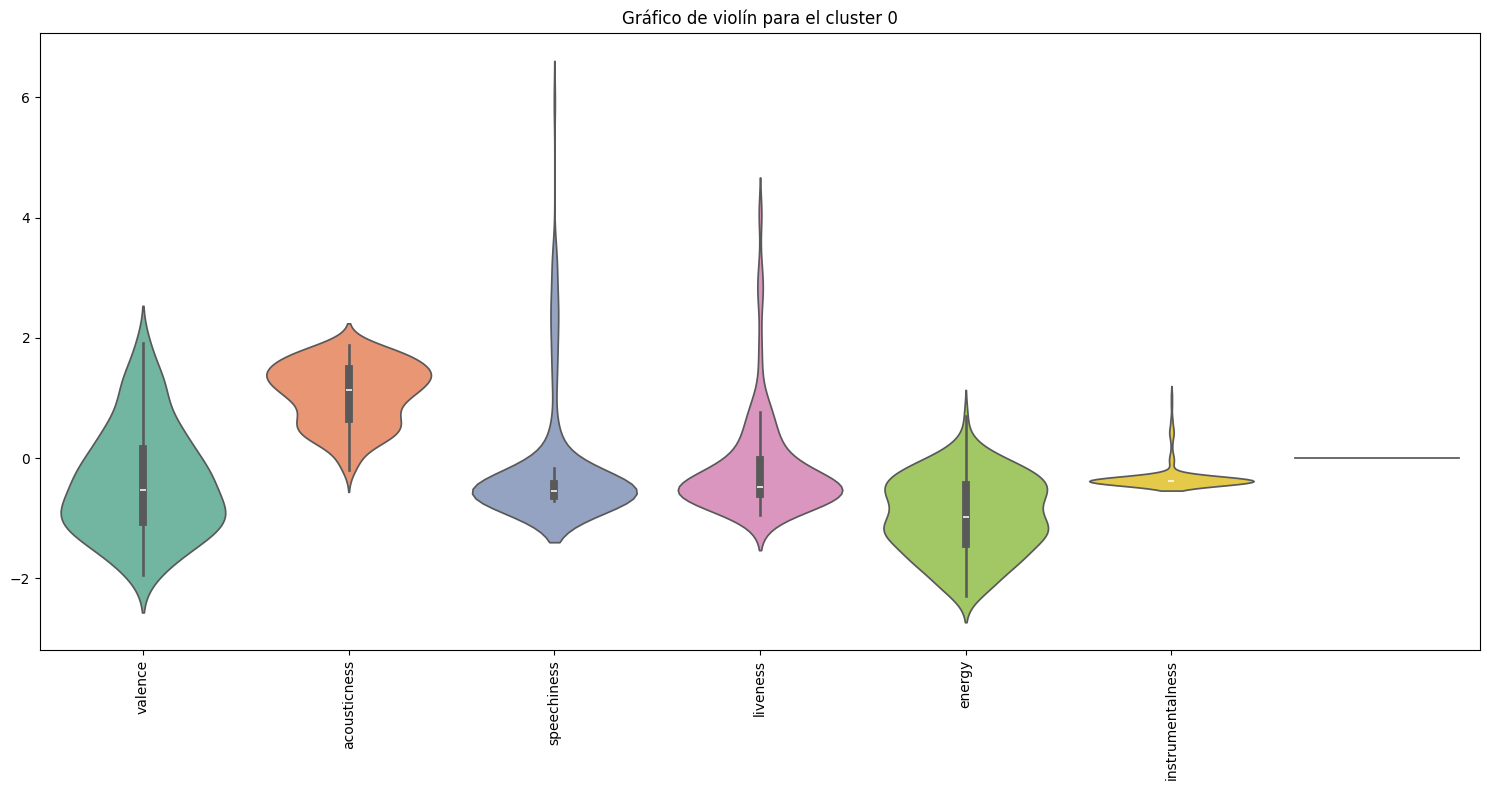

In [ ]:
###Utilisacion de arboles de decision (random forest) para utilizar solamente las variables mas interesantes

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Separación de las características (X) y de la variable objetivo (y)
X = tracks_filtrado.drop(['danceability'], axis=1)  # Reemplazar por su variable objetivo
y = tracks_filtrado['danceability']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creación y entrenamiento de un Random Forest para la selección de características
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Importancia de las características
feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Mostrar la importancia de las características
print("Importancia de las características:\n", feature_importance_df)

# Seleccionar las características más importantes (por ejemplo, aquellas cuya importancia es > 0.04)
selected_features = feature_importance_df[feature_importance_df['Importance'] > 0.04]['Feature'].tolist()
print(f"Características seleccionadas: {selected_features}")

# Crear un nuevo DataFrame con solo las características seleccionadas
tracks_selected = tracks_filtrado[selected_features]

# Normalización de las columnas numéricas con MinMaxScaler
scaler = MinMaxScaler()
tracks_normalized = scaler.fit_transform(tracks_selected)

# Aplicar PCA con 3 componentes principales
pca = PCA(n_components=3)
principal_components_3d = pca.fit_transform(tracks_normalized)

# Crear un DataFrame con las componentes principales
principal_df_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])

# Verificar la varianza explicada por las 3 primeras componentes
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por cada componente: {explained_variance}")

# Realizar el clustering K-Means con las componentes principales
n_clusters = 4  # Ajustar según los resultados
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(principal_df_3d)

# Visualizar los clusters en un gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Trazar cada cluster en un gráfico 3D
for i in range(n_clusters):
    ax.scatter(principal_df_3d['PC1'][labels == i],
               principal_df_3d['PC2'][labels == i],
               principal_df_3d['PC3'][labels == i],
               label=f'Cluster {i + 1}')

# Configurar las etiquetas de los ejes
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Clusters K-Means sobre PCA 3D')
ax.legend()
plt.show()

# Calcular el score silhouette para evaluar los clusters
silhouette_avg = silhouette_score(principal_df_3d, labels)
print(f"El score silhouette promedio es: {silhouette_avg}")

# Mostrar el gráfico del codo para determinar el número óptimo de clusters
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(principal_df_3d)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.grid(True)
plt.show()

# Visualización de los clusters con las primeras variables originales
first_13_variables = tracks_selected.iloc[:, :10].drop(columns=['tempo','duration'], errors='ignore')
clustered_data = pd.concat([first_13_variables, pd.DataFrame({'cluster': labels})], axis=1)

# Creación de gráficos de violín para comparar las variables en cada cluster
plt.figure(figsize=(15, 10))

for cluster in clustered_data['cluster'].unique():
    plt.figure(figsize=(15, 8))
    sns.violinplot(data=clustered_data[clustered_data['cluster'] == cluster], palette="Set2")
    plt.title(f'Gráfico de violín para el cluster {cluster}')
    plt.xticks(ticks=range(len(first_13_variables.columns)), labels=first_13_variables.columns, rotation=90)
    plt.tight_layout()
    plt.show()


The 4 groups we can make are :

0-Acoustic with no instru (but vocals indeed?)

2-Energic + less happy

1-Happy + energic

3-Acoustic with instru

(similares a los de antes pero el silouhette score es un poco mejor)